# Country Based Co Authorship

In [27]:
import json
import networkx as nx
import triplea.service.graph.export.export as gexport
import triplea.service.graph.analysis.ganalysis as ganaliz

In [28]:
G = nx.read_graphml(r"C:\graph-repo\country-authorship.graphml")


## Add Degree to each node

In [29]:
for node in G.nodes:
    G.nodes[node]['degree'] = G.degree(node)

## Remove Article Node

In [30]:
top = 0
for node , d in list(G.nodes(data=True)):
    top = top + 1
    node_type = d['Type']
    if node_type == 'Article':
        neighbors = list(G.neighbors(node))
        G.remove_node(node)
        for i in range(len(neighbors)):
            for j in range(i+1, len(neighbors)):
                G.add_edge(neighbors[i], neighbors[j])
                
   
    # if top > 10:
    #     break

In [49]:
# dcs = ganaliz.sorted_degree_centrality(G)
# dcs = dcs.nlargest(n=30, keep='first')
# print(dcs)

print(f'Nodes : {G.number_of_nodes()}')
print(f'Edges : {G.number_of_edges()}')

Nodes : 170
Edges : 6809


## Draw with edge

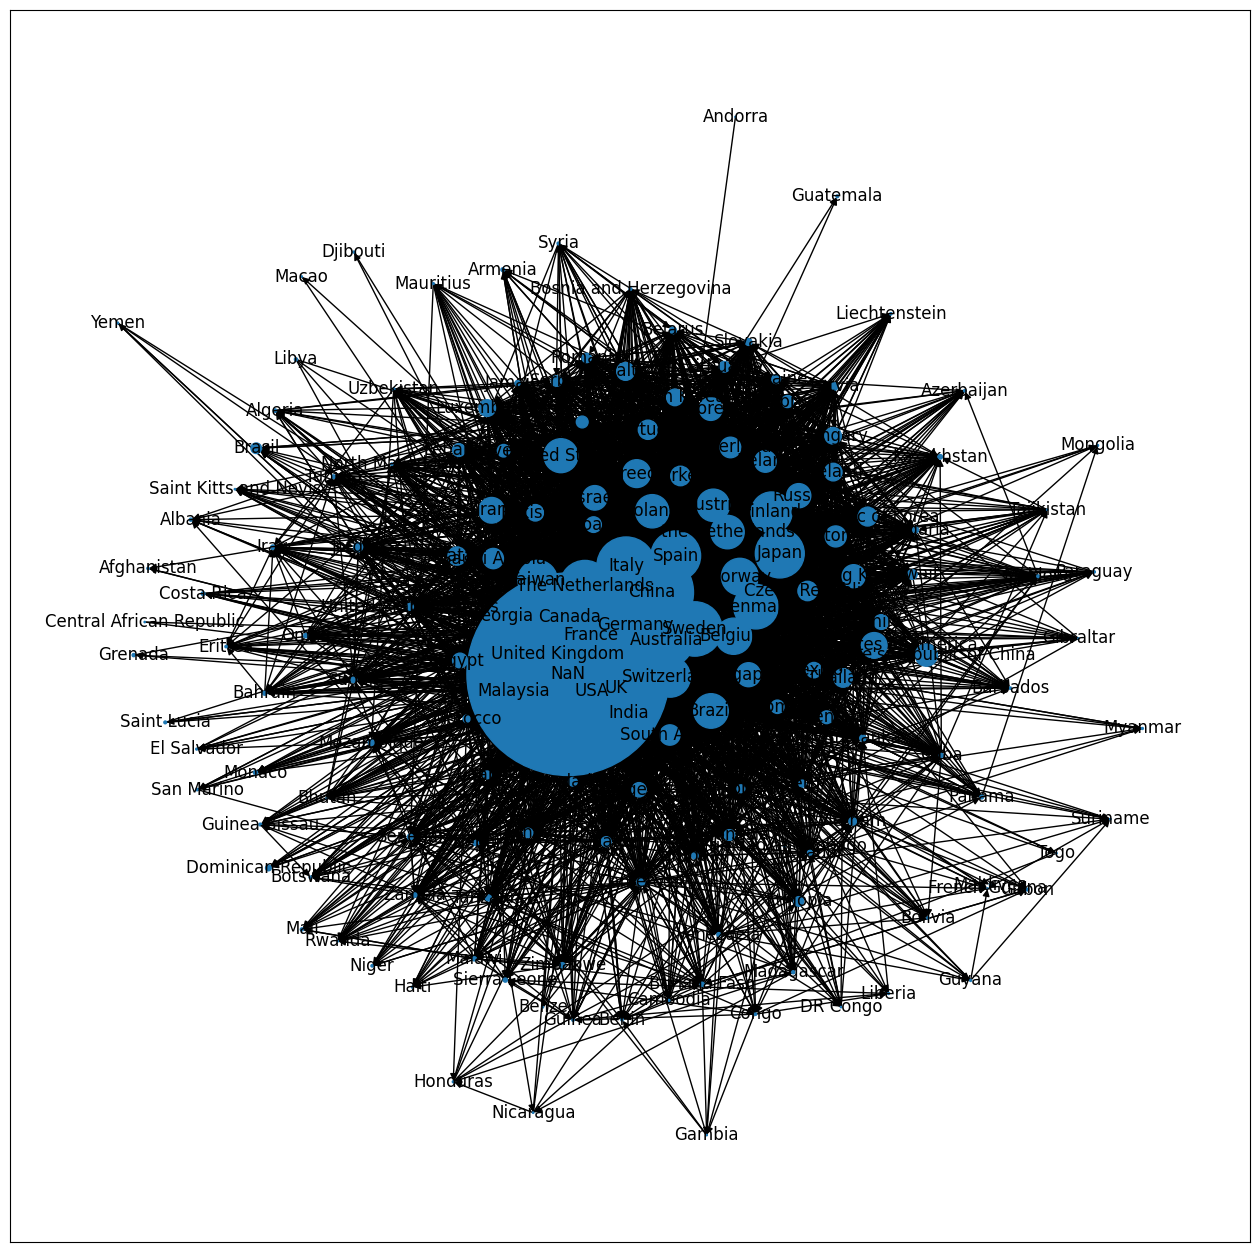

In [48]:
import matplotlib.pyplot as plt

pos = nx.kamada_kawai_layout(G)

fig = plt.figure(figsize=(16, 16))
nx.draw_networkx(G, pos= pos, node_size= [d['degree'] for node , d  in list(G.nodes(data=True))])
plt.show()
fig.savefig('output.jpg', bbox_inches='tight')



## Clustering
In this example, we create a small sample graph with two clusters and use the Louvain community detection algorithm to identify the clusters. We then create a dictionary that maps each node to its cluster membership, and a list of colors to use for the nodes based on their cluster membership. Finally, we use NetworkX to draw the graph using the spring layout algorithm and color-code the nodes based on their cluster membership.

4


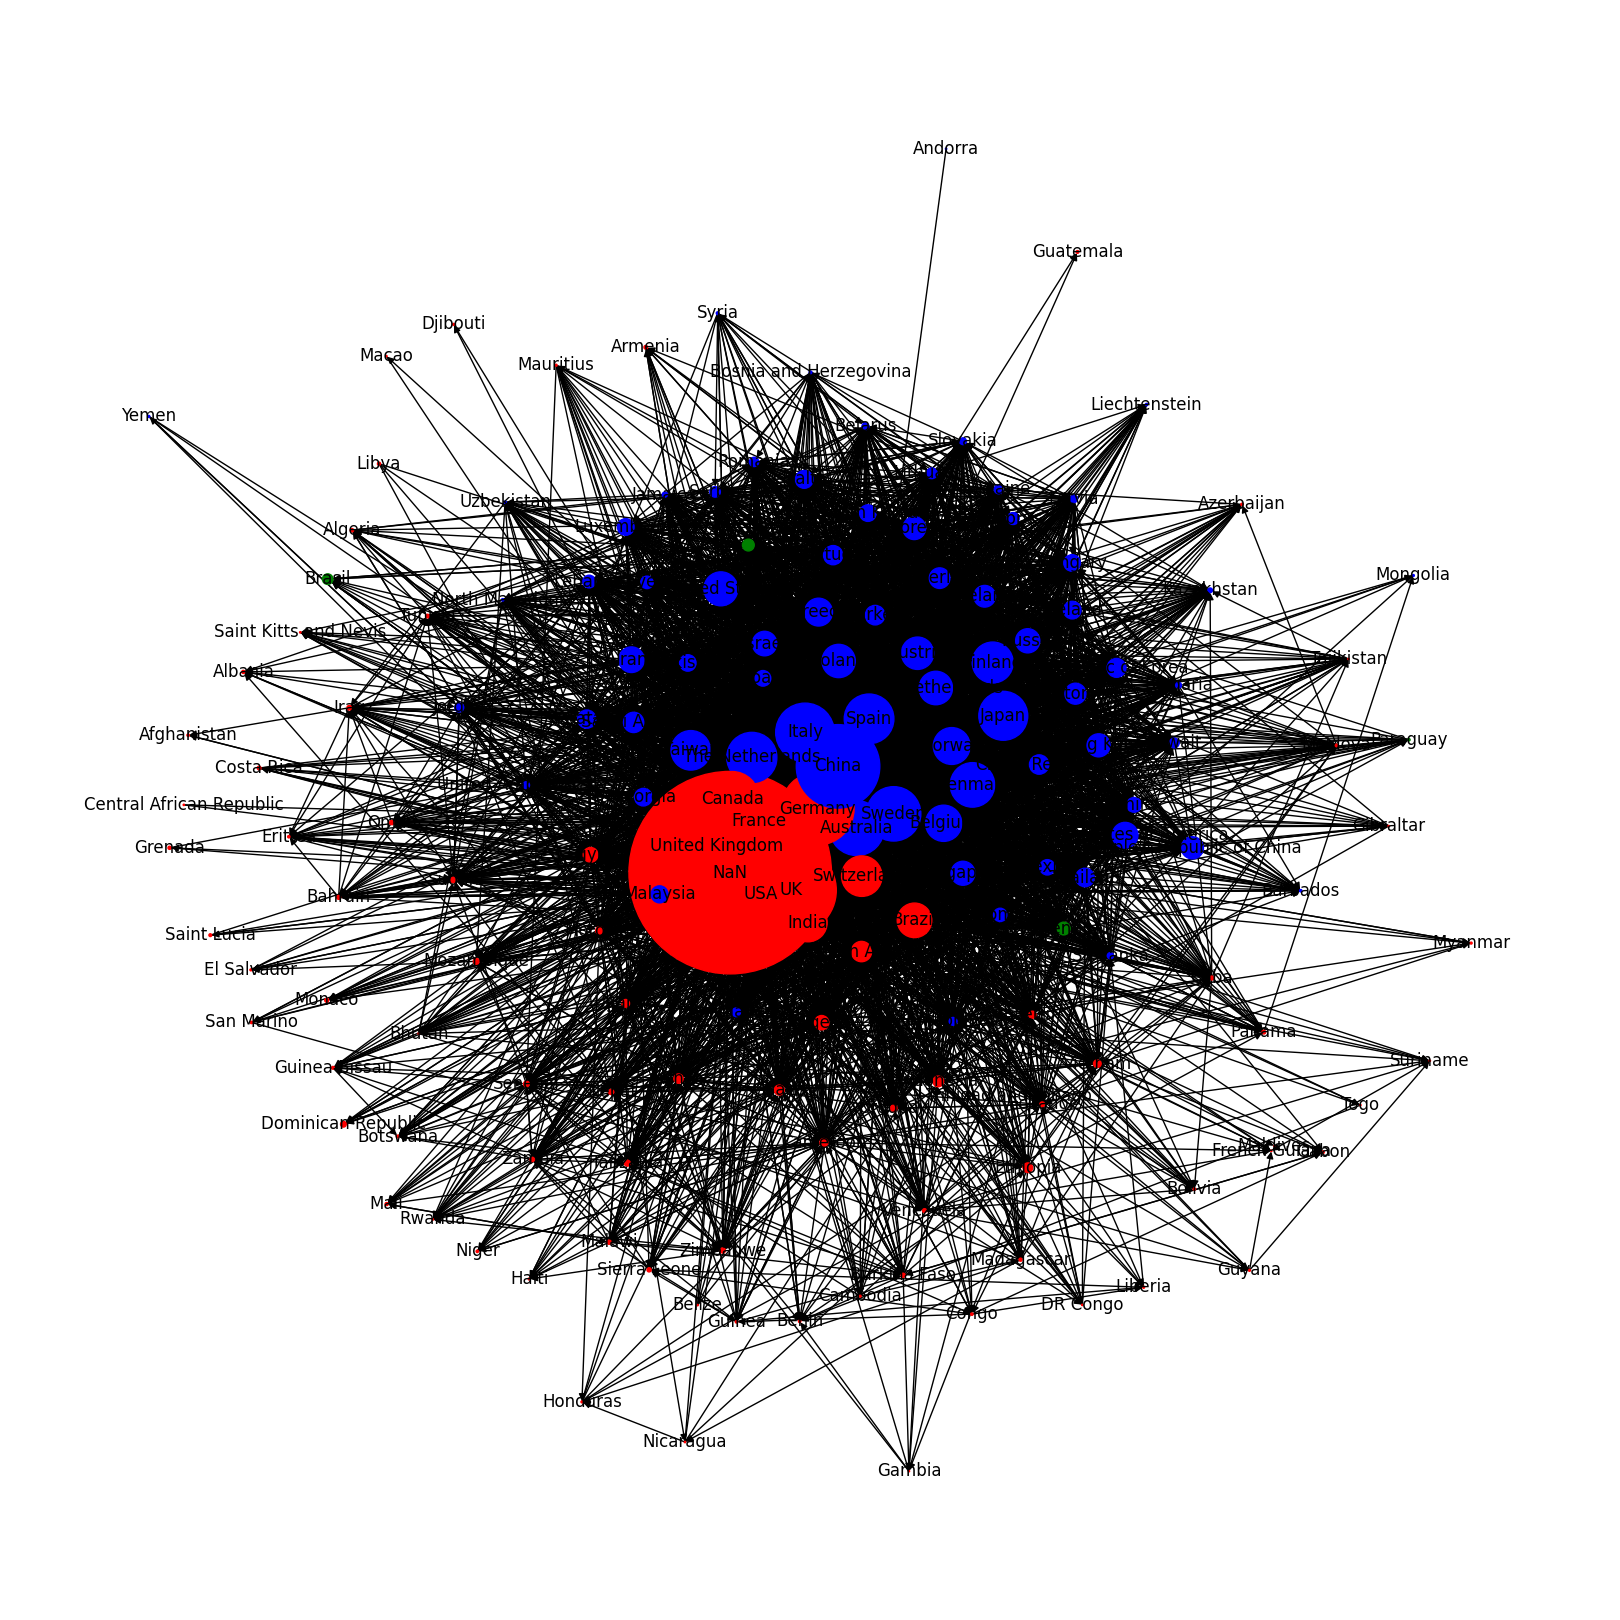

In [61]:
# Use the Louvain community detection algorithm to identify clusters
clusters = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
print(len(clusters))
# Create a dictionary that maps each node to its cluster membership
membership_dict = {}
for i, cluster in enumerate(clusters):
    for node in cluster:
        membership_dict[node] = i
        
# Create a list of colors to use for the nodes based on their cluster membership
color_list = ['red', 'blue','green', 'black']

colors = [color_list[membership_dict[node]] for node in G.nodes()]

# Draw the graph using the spring layout algorithm and color-coded nodes
# pos = nx.spring_layout(G)
pos = nx.kamada_kawai_layout(G)
fig = plt.figure(figsize=(16, 16))
nx.draw(G,
         pos,
         node_size= [d['degree'] for node , d  in list(G.nodes(data=True))],
         node_color=colors,
         with_labels=True)

# Show the plot
plt.show()

## Save GraphML

In [67]:
nx.write_graphml_lxml(G, r"C:\graph-repo\country-authorship-manipulation.graphml")

## Density-based Clustering
I should clarify that networkx is a Python library for creating and manipulating graphs, while density-based clustering typically operates on high-dimensional data. Therefore, it might not be the most natural fit to implement density-based clustering using networkx. Nonetheless, here's an example implementation of the DBSCAN algorithm (one popular density-based clustering method) using networkx:

Other popular clustering methods include k-means clustering, spectral clustering, and fuzzy clustering. Each of these methods has its own strengths and weaknesses, and the choice of which to use depends on the specific problem being solved and the nature of the data being clustered.

In [ ]:
from sklearn.cluster import DBSCAN

# Load data into a graph
# G = nx.karate_club_graph()

# Convert graph node attributes to a feature matrix
X = []
for node in G.nodes():
    X.append(list(G.nodes[node].values()))

# Run DBSCAN clustering
clustering = DBSCAN(eps=1.0, min_samples=3).fit(X)

# Add cluster labels as node attributes
for i, label in enumerate(clustering.labels_):
    G.nodes[i]['cluster'] = label

# Print number of clusters found
num_clusters = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
print("Number of clusters:", num_clusters)

## K-mean


In [ ]:
import networkx as nx
import random

def k_means(G, k):
    # Initialize the centroids randomly
    centroids = random.sample(list(G.nodes()), k)
    
    # Loop until convergence
    while True:
        # Assign each node to its nearest centroid
        clusters = {centroid: [] for centroid in centroids}
        for node in G.nodes():
            try:
                distances = [(nx.shortest_path_length(G, node, centroid), centroid) for centroid in centroids]
            except nx.NetworkXNoPath:
                print ('No path')
            closest_centroid = min(distances)[1]
            clusters[closest_centroid].append(node)
        
        # Calculate the new centroids
        new_centroids = []
        for centroid, nodes in clusters.items():
            x = sum([G.nodes[node]['x'] for node in nodes])/len(nodes)
            y = sum([G.nodes[node]['y'] for node in nodes])/len(nodes)
            new_centroids.append((x,y))
        
        # Check for convergence
        if set(new_centroids) == set(centroids):
            break
        
        centroids = new_centroids
    
    return clusters

c = k_means(G,10)
print(len(c))

## Export Json File for VOSviewer



In [85]:

j = {}
items = []
links = []

n = 0
for node in G.nodes:
    G.nodes[node]['id'] = n
    n = n + 1

for node , d in list(G.nodes(data=True)):
    item = {}
    item['id'] = d['id']
    if 'Name' in d:
        item['label'] = d['Name']
    else:
        item['label'] = "NAN"
    
    items.append(item)

for s , d in list(G.edges()):
    link = {}
    link['source_id'] = G.nodes(data=True)[s]['id']
    link['target_id'] = G.nodes(data=True)[d]['id']
    links.append(link)

gml = {}
gml['network'] = {'items' : items, 'links' : links}

with open("VOS.json", "w") as file:
    json.dump(gml, file)
